In [6]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
import yaml
import open3d as o3d
from tqdm.notebook import tqdm

# Add the project directory to the Python path
sys.path.append('..')

# Import project modules
from src.preprocessing.image_loader import load_image_sequence, resize_images
from src.preprocessing.image_preprocessing import enhance_contrast
from src.feature_extraction.sift_extractor import extract_features_from_image_set
from src.feature_extraction.feature_matcher import match_image_pairs, geometric_verification
from src.sfm.camera_calibration import estimate_camera_matrix
from src.sfm.pose_estimation import estimate_poses_incremental
from src.sfm.triangulation import triangulate_all_points, merge_triangulated_points
from src.sfm.bundle_adjustment import run_global_ba
from src.dense_reconstruction.mvs import process_mvs
from src.dense_reconstruction.point_cloud import process_dense_reconstruction
from src.surface_reconstruction.mesh_generation import process_point_cloud_to_mesh
from src.surface_reconstruction.texture_mapping import create_textured_mesh_from_point_cloud

from src.visualization.plot_matches import plot_matches, plot_feature_matching_analysis
from src.visualization.point_cloud_visualizer import plot_interactive_point_cloud, create_point_cloud_animation
from src.visualization.camera_visualizer import plot_interactive_camera_poses
from src.visualization.mesh_visualizer import visualize_mesh_o3d, plot_interactive_mesh

# Set up matplotlib for inline display
%matplotlib inline
# For newer matplotlib versions (3.6+)
plt.style.use('default')

In [33]:
# Define configuration
config = {
    'preprocessing': {
        'resize_max_dimension': 800,
        'enhance_contrast': True
    },
    'features': {
        'method': 'sift',
        'max_features': 5000
    },
    'matching': {
        'ratio_threshold': 0.75,
        'geometric_verification': True,
        'min_matches': 15,
        'verification_method': 'fundamental',
        'ransac_threshold': 3.5
    },
    'calibration': {
        'focal_length_factor': 1.2
    },
    'sfm': {
        'incremental': True,
        'refine_poses': True,
        'min_triangulation_angle_deg': 2.0,
        'reprojection_error_threshold': 4.0
    },
    'mvs': {
        'min_disparity': 0,
        'num_disparities': 96,
        'block_size': 9,
        'filter_depths': True,
        'consistency_threshold': 0.02,  # MUCH more strict - only keep high-quality points
        'num_source_views': 5
    },
    'point_cloud': {
        'voxel_size': 0.03,  # Much larger voxel size to reduce points
        'nb_neighbors': 50,  # More neighbors for stricter filtering
        'std_ratio': 1.0,    # Even stricter outlier removal
        'confidence_threshold': 0.7  # Much higher threshold = much fewer points
    },
    'surface': {
        'method': 'poisson',
        'depth': 8,
        'cleanup': True
    },
    'visualization': {
        'point_size': 2,
        'camera_size': 6,
        'point_color_method': 'rgb'
    }
}

# Create output directory for results
output_dir = "../data/results/"
os.makedirs(output_dir, exist_ok=True)

print("Configuration loaded and output directory created.")



Configuration loaded and output directory created.


Loading images...
Loaded 37 images.
Resized images to maximum dimension of 800 pixels.
Enhanced image contrast.


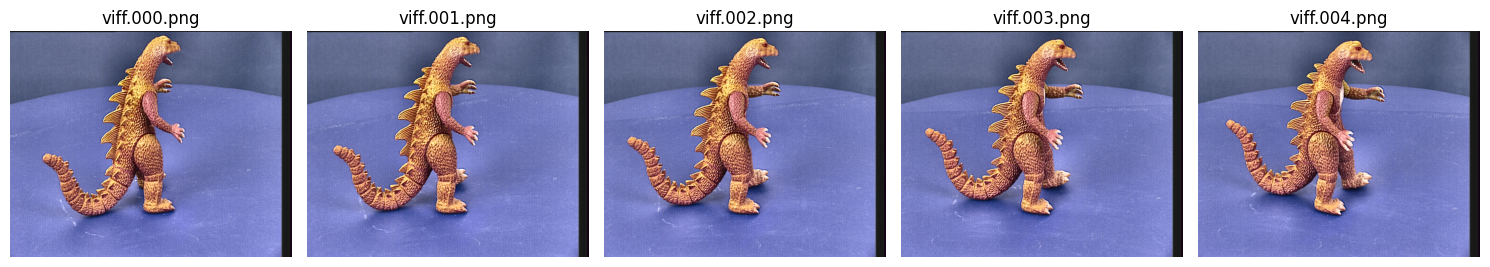

In [34]:
# Define path to dinosaur dataset
dataset_path = '../data/dinosaur/'

# Load images
print("Loading images...")
images = load_image_sequence(dataset_path, pattern="viff.*.png")
print(f"Loaded {len(images)} images.")

# Resize images if needed
max_dim = config['preprocessing']['resize_max_dimension']
images = resize_images(images, max_dimension=max_dim)
print(f"Resized images to maximum dimension of {max_dim} pixels.")

# Enhance contrast if specified
if config['preprocessing']['enhance_contrast']:
    images = enhance_contrast(images)
    print("Enhanced image contrast.")

# Display a subset of the images
n_images = min(5, len(images))
fig, axes = plt.subplots(1, n_images, figsize=(15, 5))

for i in range(n_images):
    img, filename = images[i]
    axes[i].imshow(img)
    axes[i].set_title(filename)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Extracting features from images...
viff.000.png: 1852 keypoints
viff.001.png: 1887 keypoints
viff.002.png: 1820 keypoints
viff.003.png: 1892 keypoints
viff.004.png: 1711 keypoints
viff.005.png: 1641 keypoints
viff.006.png: 1631 keypoints
viff.007.png: 1580 keypoints
viff.008.png: 1482 keypoints
viff.009.png: 1305 keypoints
viff.010.png: 1131 keypoints
viff.011.png: 1088 keypoints
viff.012.png: 1064 keypoints
viff.013.png: 1091 keypoints
viff.014.png: 1108 keypoints
viff.015.png: 1279 keypoints
viff.016.png: 1339 keypoints
viff.017.png: 1535 keypoints
viff.018.png: 1642 keypoints
viff.019.png: 1771 keypoints
viff.020.png: 1890 keypoints
viff.021.png: 1923 keypoints
viff.022.png: 1971 keypoints
viff.023.png: 2007 keypoints
viff.024.png: 2100 keypoints
viff.025.png: 2032 keypoints
viff.026.png: 1893 keypoints
viff.027.png: 1882 keypoints
viff.028.png: 1720 keypoints
viff.029.png: 1560 keypoints
viff.030.png: 1559 keypoints
viff.031.png: 1518 keypoints
viff.032.png: 1694 keypoints
viff.03

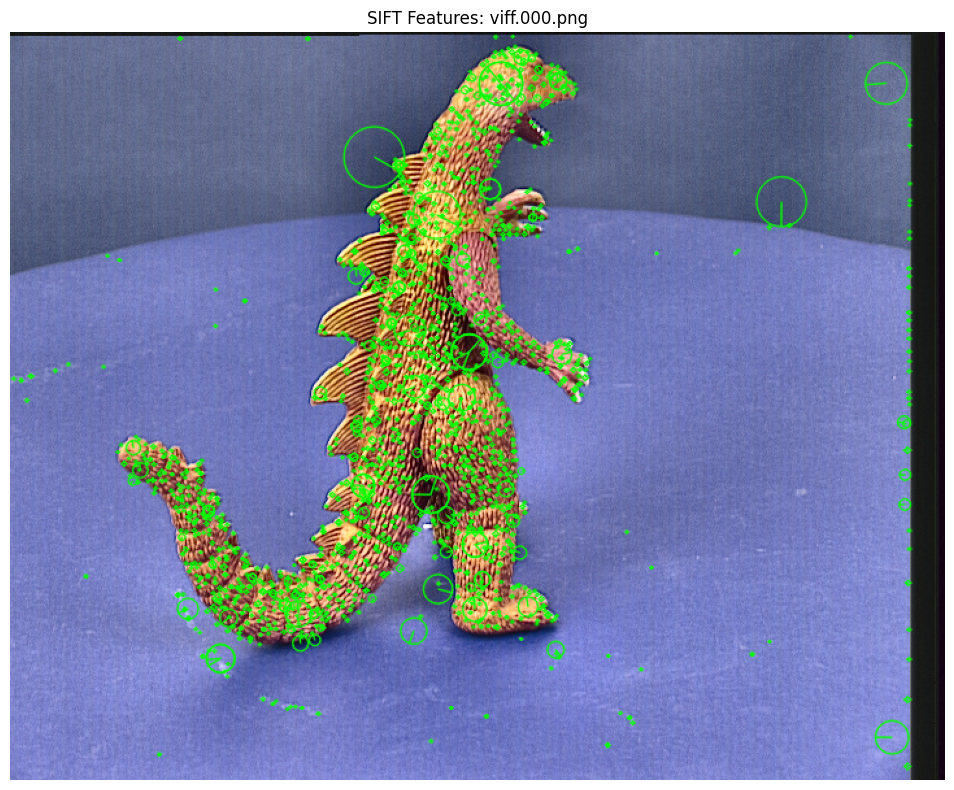


Matching features between image pairs...
Successfully matched 37 image pairs.


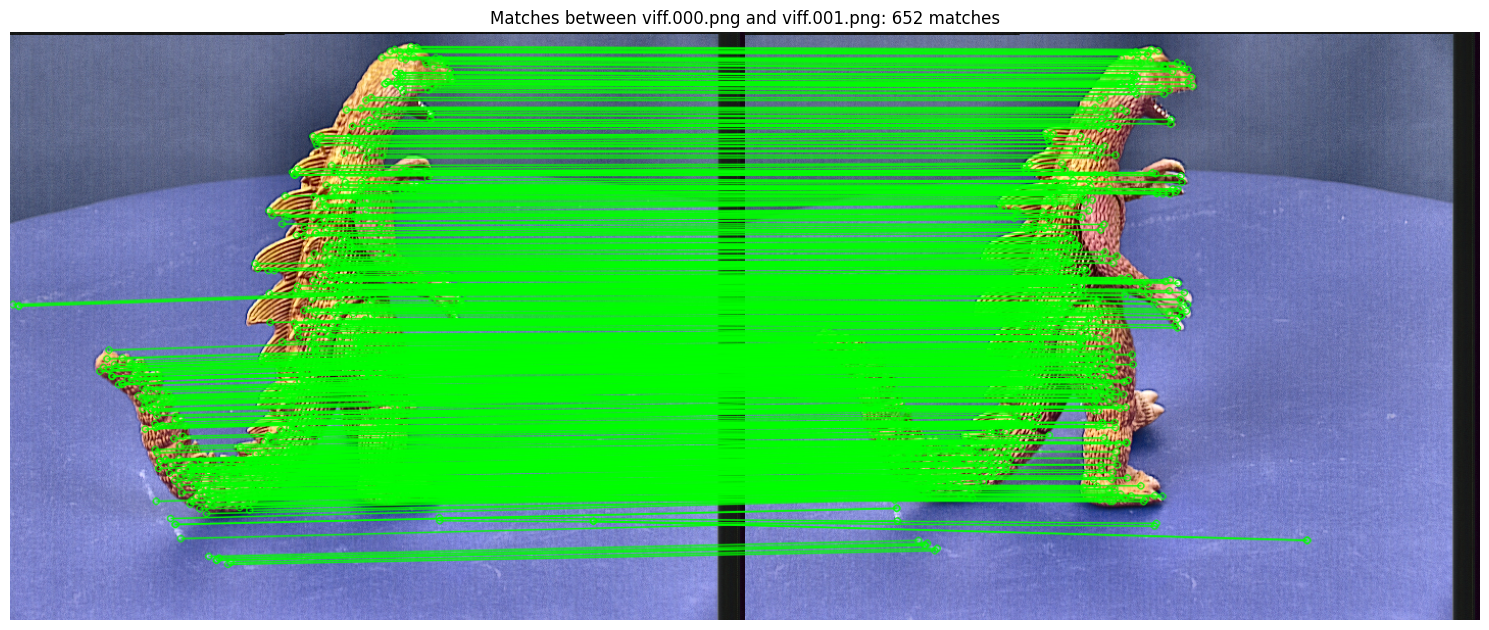

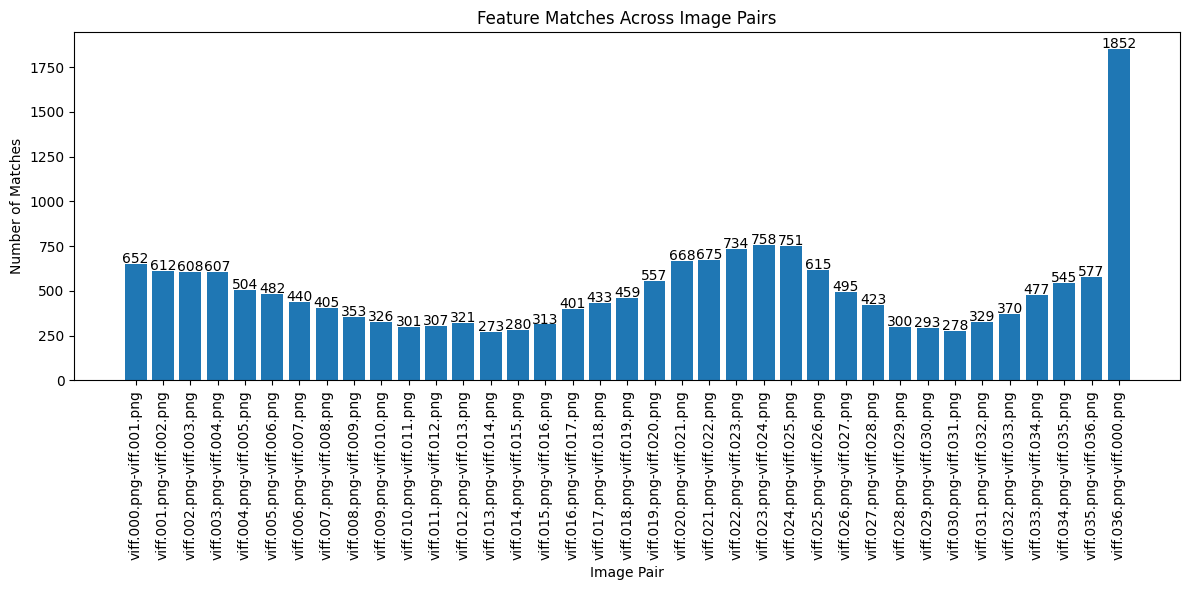

In [37]:
# Extract features
print("\nExtracting features from images...")
feature_method = config['features']['method']
max_features = config['features']['max_features']

features_dict = extract_features_from_image_set(images, method=feature_method, n_features=max_features)

# Print feature counts
for filename, (keypoints, descriptors) in features_dict.items():
    print(f"{filename}: {len(keypoints)} keypoints")

# Visualize keypoints on a sample image
sample_img, sample_filename = images[0]
sample_keypoints, _  = features_dict[sample_filename]

# Plot keypoints
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(cv2.drawKeypoints(sample_img, sample_keypoints, None, 
                          color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
ax.set_title(f"{feature_method.upper()} Features: {sample_filename}")
ax.axis('off')
plt.tight_layout()
plt.show()

# Match features between consecutive image pairs plus loop closure
print("\nMatching features between image pairs...")
filenames = [filename for _, filename in images]

# Create image pairs (consecutive images and loop closure)
image_pairs = [(filenames[i], filenames[i+1]) for i in range(len(filenames)-1)]
image_pairs.append((filenames[-1], filenames[0]))  # Loop closure

# Match features
matches_dict = match_image_pairs(
    features_dict, 
    image_pairs, 
    config['matching']['ratio_threshold'],
    config['matching']['geometric_verification'],
    config['matching']['min_matches']
)

print(f"Successfully matched {len(matches_dict)} image pairs.")

# Display matches for a sample pair
if len(matches_dict) > 0:
    # Choose a sample pair
    sample_pair = list(matches_dict.keys())[0]
    img1_name, img2_name = sample_pair
    kp1, kp2, matches = matches_dict[sample_pair]

    # Get the images
    img1 = next(img for img, filename in images if filename == img1_name)
    img2 = next(img for img, filename in images if filename == img2_name)

    # Plot matches
    plot_matches(img1, kp1, img2, kp2, matches[:5000],  # Only plot first 100 matches for clarity
                title=f"Matches between {img1_name} and {img2_name}: {len(matches)} matches")

    # Show matching statistics across all pairs
    plot_feature_matching_analysis(matches_dict, figsize=(12, 6))

In [39]:
# Estimate camera intrinsics
print("\nEstimating camera intrinsics...")
sampleimg, _  = images[0]
image_shape = sample_img.shape
focal_length_factor = config['calibration']['focal_length_factor']
focal_length = focal_length_factor * max(image_shape[0], image_shape[1])
K = estimate_camera_matrix(image_shape, focal_length)

print("Estimated camera matrix:")
print(K)

# Estimate camera poses using sequential SfM
print("\nEstimating camera poses using Structure from Motion...")
camera_poses = estimate_poses_incremental(matches_dict, K, min_matches=8)  # Lower threshold

print(f"Estimated poses for {len(camera_poses)} cameras.")

# Visualize camera poses
if len(camera_poses) > 0:
    # Extract camera positions for visualization
    camera_positions = {name: -R.T @ t for name, (R, t) in camera_poses.items()}

    # Plot camera positions
    plot_interactive_camera_poses(camera_poses)


Estimating camera intrinsics...
Estimated camera matrix:
[[864.   0. 360.]
 [  0. 864. 288.]
 [  0.   0.   1.]]

Estimating camera poses using Structure from Motion...
Initializing with pair: viff.000.png and viff.001.png (652 matches)
Triangulated 652 initial points
Attempting to add image: viff.002.png
Found 300 2D-3D correspondences for viff.002.png
PnP successful with 299 inliers. Mean reprojection error: 0.93 pixels
Added pose for viff.002.png using 299 / 300 points
  Triangulated 308 new points with viff.001.png and viff.002.png
Attempting to add image: viff.003.png
Found 140 2D-3D correspondences for viff.003.png
PnP successful with 139 inliers. Mean reprojection error: 1.51 pixels
Added pose for viff.003.png using 139 / 140 points
  Triangulated 467 new points with viff.002.png and viff.003.png
Attempting to add image: viff.004.png
Found 222 2D-3D correspondences for viff.004.png
PnP successful with 221 inliers. Mean reprojection error: 1.99 pixels
Added pose for viff.004.png 

In [ ]:
# Triangulate 3D points with stricter thresholds
print("\nTriangulating 3D points...")
points_3d, point_observations = triangulate_all_points(
    camera_poses, 
    matches_dict, 
    K,
    max_reprojection_error=config['sfm']['reprojection_error_threshold'],
    min_triangulation_angle_deg=config['sfm']['min_triangulation_angle_deg']
)

print(f"Triangulated {len(points_3d)} 3D points.")

# Merge close points with tighter threshold
merged_points, merged_observations = merge_triangulated_points(
    points_3d, 
    point_observations,
    distance_threshold=0.01  # Tighter threshold for merging
)
print(f"After merging: {len(merged_points)} 3D points.")

# Bundle adjustment with more iterations
if config['sfm']['refine_poses'] and len(merged_points) > 0:
    print("\nRunning extended bundle adjustment...")
    refined_poses, refined_points, _ = run_global_ba(
        camera_poses, 
        matches_dict, 
        K,
        max_iterations=50  # Increased from default (likely 20)
    )
    camera_poses = refined_poses
    points_3d = refined_points
    print("Bundle adjustment complete.")

# Filter point cloud to better represent the dinosaur
if len(points_3d) > 0:
    print("\nFiltering and visualizing sparse point cloud...")
    points_array = np.array(points_3d)
    
    # Create a point cloud for filtering
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_array)
    
    # Remove statistical outliers
    print("Removing outliers...")
    pcd, _ = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=1.0)
    
    # Get filtered points
    filtered_points = np.asarray(pcd.points)
    print(f"Filtered to {len(filtered_points)} points")
    
    # Assign colors by position (better visualization)
    colors = np.zeros_like(filtered_points)
    # Map x,y,z to r,g,b normalized to [0,1]
    mins = np.min(filtered_points, axis=0)
    maxs = np.max(filtered_points, axis=0)
    ranges = maxs - mins
    for i in range(3):
        if ranges[i] > 0:
            colors[:, i] = (filtered_points[:, i] - mins[i]) / ranges[i]
    
    # Interactive visualization
    plot_interactive_point_cloud(filtered_points, colors, title="Improved Sparse 3D Reconstruction")

    # Save sparse point cloud
    sparse_cloud_file = os.path.join(output_dir, "dinosaur_sparse.ply")
    pcd.colors = o3d.utility.Vector3dVector(colors)
    o3d.io.write_point_cloud(sparse_cloud_file, pcd)
    print(f"Saved sparse point cloud to {sparse_cloud_file}")

In [ ]:
# Cell 1: Preprocess images for MVS reconstruction with minimal filtering
print("\nPreprocessing images for MVS reconstruction...")
processed_images = []
for img, name in images:
    # Apply light noise reduction while preserving edges
    filtered = cv2.bilateralFilter(img, 5, 50, 50)  # Reduced filter size and strength
    
    # Apply gentle contrast enhancement to improve feature matching
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))  # Reduced clip limit
    if len(img.shape) == 3:
        # For color images, enhance luminance only
        lab = cv2.cvtColor(filtered, cv2.COLOR_RGB2LAB)
        lab[:,:,0] = clahe.apply(lab[:,:,0])
        enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    else:
        enhanced = clahe.apply(filtered)
    
    processed_images.append((enhanced, name))

# Update MVS configuration for better depth estimation
mvs_config = config['mvs'].copy()
mvs_config.update({
    'block_size': 9,           # Smaller block size for better detail
    'num_source_views': 5,     # More source views for better consistency
    'consistency_threshold': 0.05,  # Slightly less strict to keep more points
})

# Run Multi-View Stereo with preprocessed images
print("\nRunning Multi-View Stereo for dense reconstruction...")
mvs_results = process_mvs(processed_images, camera_poses, K, mvs_config)

# Extract depth maps
depth_maps = mvs_results['filtered_depth_maps']
confidence_maps = mvs_results['confidence_maps']

print(f"Generated {len(depth_maps)} depth maps.")

# Visualize a sample depth map
if len(depth_maps) > 0:
    # Choose a sample depth map
    sample_name = list(depth_maps.keys())[0]
    depth_map = depth_maps[sample_name]
    
    # Normalize depth for visualization
    valid_mask = depth_map > 0
    if np.any(valid_mask):
        min_depth = np.min(depth_map[valid_mask])
        max_depth = np.max(depth_map[valid_mask])
        normalized_depth = np.zeros_like(depth_map)
        normalized_depth[valid_mask] = (depth_map[valid_mask] - min_depth) / (max_depth - min_depth)
        
        # Display depth map
        plt.figure(figsize=(10, 8))
        plt.imshow(normalized_depth, cmap='jet')
        plt.colorbar(label='Normalized Depth')
        plt.title(f"Depth Map: {sample_name}")
        plt.axis('off')
        plt.show()

In [ ]:
point_cloud_config = config['point_cloud'].copy()
point_cloud_config.update({
    'voxel_size': 0.02,       # Balanced voxel size
    'confidence_threshold': 0.5  # Lower threshold to keep more points
})

print("\nGenerating dense point cloud from depth maps...")
dense_results = process_dense_reconstruction(
    processed_images, camera_poses, K, depth_maps, confidence_maps, point_cloud_config)

# Extract results
dense_points = dense_results['filtered_points']
dense_colors = dense_results['filtered_colors']

if len(dense_points) > 0:
    print(f"Initial dense point cloud contains {len(dense_points)} points.")
    
    # Create point cloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(dense_points)
    pcd.colors = o3d.utility.Vector3dVector(dense_colors)
    
    # Apply minimal cleaning - only remove obvious outliers
    print("Removing outliers...")
    pcd, _ = pcd.remove_statistical_outlier(nb_neighbors=30, std_ratio=2.0)  # More permissive
    
    # Apply light downsampling to maintain details while reducing redundancy
    print("Applying light downsampling...")
    pcd = pcd.voxel_down_sample(voxel_size=0.05)  # Smaller voxel size to preserve details
    
    # Get the filtered points
    dense_points = np.asarray(pcd.points)
    dense_colors = np.asarray(pcd.colors)
    
    print(f"Final dense point cloud contains {len(dense_points)} points.")
    
    # Visualize dense point cloud
    plot_interactive_point_cloud(dense_points, dense_colors, title="Dense 3D Reconstruction")
    
    # Save dense point cloud
    dense_cloud_file = os.path.join(output_dir, "dinosaur_dense.ply")
    o3d.io.write_point_cloud(dense_cloud_file, pcd)
    print(f"Saved dense point cloud to {dense_cloud_file}")

In [ ]:
# Generate textured mesh
print("\nGenerating textured mesh...")
textured_mesh = create_textured_mesh_from_point_cloud(
    dense_points, dense_colors, images, camera_poses, K, 
    reconstruction_method=config['surface']['method'])

# Visualize textured mesh (this will open an Open3D window)
print("\nVisualizing textured mesh (this will open a new window)...")
visualize_mesh_o3d(textured_mesh, window_name="Textured Mesh")

# Save textured mesh
textured_mesh_file = os.path.join(output_dir, "dinosaur_textured.obj")
o3d.io.write_triangle_mesh(textured_mesh_file, textured_mesh)
print(f"Saved textured mesh to {textured_mesh_file}")

In [ ]:
# Create interactive mesh visualization using Plotly
print("\nCreating interactive mesh visualization...")

# Extract mesh data for Plotly
vertices = np.asarray(textured_mesh.vertices)
triangles = np.asarray(textured_mesh.triangles)
vertex_colors = np.asarray(textured_mesh.vertex_colors) if textured_mesh.has_vertex_colors() else None

# Create interactive plot
plot_interactive_mesh(vertices, triangles, vertex_colors, title="Interactive 3D Dinosaur Model")

# Create rotating animation (optional)
print("\nCreating 360° animation of the model...")
animation = create_point_cloud_animation(
    dense_points, dense_colors, n_frames=36, 
    output_file=os.path.join(output_dir, "dinosaur_animation.html"))

print("\n3D reconstruction pipeline complete!")
print(f"All results saved to: {output_dir}")

# Display summary of the reconstruction
print("\nReconstruction Summary:")
print(f"Images processed: {len(images)}")
print(f"Camera poses estimated: {len(camera_poses)}")
print(f"Sparse points: {len(points_3d)}")
print(f"Dense points: {len(dense_points)}")
print(f"Mesh vertices: {len(textured_mesh.vertices)}")
print(f"Mesh triangles: {len(textured_mesh.triangles)}")

In [ ]:
# Simplify and optimize mesh for 3D printing (optional)
print("\nOptimizing mesh for export...")

# Make a copy of the mesh for optimization
export_mesh = o3d.geometry.TriangleMesh(textured_mesh)

# Remove any non-manifold edges
export_mesh.remove_non_manifold_edges()

# Fill holes
export_mesh = export_mesh.filter_smooth_simple(5)  # Smooth mesh

# Simplify mesh to reduce polygon count
target_triangles = int(len(export_mesh.triangles) * 0.5)  # Reduce to 50%
export_mesh = export_mesh.simplify_quadric_decimation(target_triangles)

# Fix mesh normals
export_mesh.compute_vertex_normals()

# Save optimized mesh in multiple formats
o3d.io.write_triangle_mesh(os.path.join(output_dir, "dinosaur_optimized.obj"), export_mesh)
o3d.io.write_triangle_mesh(os.path.join(output_dir, "dinosaur_optimized.stl"), export_mesh)

print("Optimized mesh exported in OBJ and STL formats, suitable for 3D printing and other applications.")